# Import the dependencies

We are going to use only numpy for the execution of Neural Network and those are going to fully connected network.
Torch and matplot are going to be used for importing dataset and visualising the same

In [115]:
import numpy as np
from matplotlib import pyplot as plt
import torch

# Intialization of Layers and Nodes
We need a function that takes the architecture of the network(i.e., the number of layers and nodes in each layer) and initializes the weights and biases

In [116]:

# Initialize the parameters for the neural network
def initialize_parameters(layer_dims):
    np.random.seed(1)  # for reproducibility
    parameters = {}
    
    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        print('W' + str(l) + ' shape: ' + str(parameters['W' + str(l)].shape))
        print('b' + str(l) + ' shape: ' + str(parameters['b' + str(l)].shape))
    return parameters


Define activation function such as ReLu, sigmoid, tanh and softmax and their derivatives
1. Sigmoid Function: $\sigma(Z)=\frac{1}{1+e^{-Z}}$
2. ReLU function: $ReLU(z)=\max(0,z)$
3. Tanh Function: $tanh(z)=\frac{e^z-e^{-z}}{e^z+e^{-z}}$
4. Softmax Function: $sofmax(z_i)=\frac{e^{z_i}}{\sum_j e_{z_j}}$


In [117]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def tanh(Z):
    return np.tanh(Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def tanh_backward(dA, Z):
    return dA * (1 - np.tanh(Z)**2)

def softmax_backward(dA, Z):
    return dA


In [118]:
activation_functions = {
    "sigmoid": sigmoid,
    "relu": relu,
    "tanh": tanh,
    "softmax": softmax
    }

activation_functions_backward = {
    "sigmoid": sigmoid_backward,
    "relu": relu_backward,
    "tanh": tanh_backward,
    "softmax": softmax_backward
    }

# Forward Pass
Use the chosen activation function to pass the information about your datas.
1. $a^{(1)}={w^{(1)}}^Tx+b^{(1)}$
2. $a^{(i)}={w^{(i)}}^T.\sigma(a^{(i-1)})+b^{(i)}$ for $i>1$

Linear Forward would take care of $w^Tx+b$ and activate_forward are just going to activate these functions and we are going to keep track of $(w^{(i)},b^{(i)},a^{(i-1)} )$

In [119]:
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache

def activate_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "relu":
        A = relu(Z)
    elif activation == "tanh":
        A = tanh(Z)
    elif activation == "softmax":
        A = softmax(Z)
    
    activation_cache = Z
    cache = (linear_cache, activation_cache)
    return A, cache

# Loss Function

Create a set of Loss function which you would wish to minimize for your job
1. Mean Squared Error(MSE)
Mean Square error is used for regression problems and is given by $MSE=\frac{1}{m}\sum_{i=1}^{m}(y_i-\hat{y_i})^2$.

For this exercise, we are only going to use mean squared error and try to minimize it.

In [120]:
def mean_squared_error(Y_hat, Y):
    m = Y.shape[1]
    return np.sum((Y_hat - Y)**2) / (2 * m)

def mean_squared_error_backward(Y_hat, Y):
    m = Y.shape[1]
    return (Y_hat - Y) / m

# Cross-entropy loss and its derivative
def cross_entropy_loss(AL, Y):
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(AL + 1e-8)) / m  # Adding epsilon for numerical stability
    return cost

def cross_entropy_loss_backward(AL, Y):
    return AL - Y


# Backward Propagation

Implement the backward pass using the derivatives of the activation functions and the MSE Loss!
Backward Propagation involves computing the gradients of the loss function with respect to the parameters of the neural network. These gradients are then used to update the parameters. We will use the derivative of the activation functions and the MSE loss we 've implemented.
Please note, back propagation is nothing but chain rule where we must keep track of what function we are differentiating.
Goal is to find the following:

1.$\frac{dE}{dW}=2\frac{\hat{y}-y}{m}.\frac{d\hat{y}}{dW}$

2.$\frac{dE}{db}=2\frac{\hat{y}-y}{m}.\frac{d\hat{y}}{db}$

If you notice the way functions were defined earlier, its convenient to determine derivative using the following idea:

1. $\frac{dE}{da^{(i)}}.\frac{da^{(i)}}{dw^{(i)}}$

Hence, backward_propagation would initate the computation recursively using the function activate_backward, whose job is to return the derivative of activation function at $x=a^{(i-1)}$ and linear_backward, whose job is to return the derivative of functions inside activation function with respect to W and b and of course compute $W^T.\delta$ as mention in the notes attached to this repo.


In [121]:
#linear backward step
def linear_backward(dz, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = np.dot(dz, A_prev.T) / m
    db = np.sum(dz, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dz)
    
    return dA_prev, dW, db

#activation_backward
def activate_backward(dz, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "sigmoid":
        dA = sigmoid_backward(dz, activation_cache)
    elif activation == "relu":
        dA = relu_backward(dz, activation_cache)
    elif activation == "tanh":
        dA = tanh_backward(dz, activation_cache)
    elif activation == "softmax":
        dA = softmax_backward(dz, activation_cache)
    
    return linear_backward(dA, linear_cache)

# Full backward Propagation
def backward_propagation(Y_hat, Y, caches, activations):
    grads = {}
    L = len(caches) # the number of layers
    m = Y.shape[1] # number of samples
    Y = Y.reshape(Y_hat.shape) # after this line, Y is the same shape as Y_hat

    # Initializing the backpropagation
    dA = mean_squared_error_backward(Y_hat, Y)

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = activate_backward(dA, current_cache, activations[L - 1])

    # Loop from l=L-2 to l=0
    for l in reversed(range(L - 1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activate_backward(grads["dA" + str(l + 2)], current_cache, activations[l])
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads
    

# Optimizers

This might be the most important step of this whole setup since everything depends on this small step.

1. Stochastic Gradient Descent(SGD)
2. Momentum
3. RMSprop
4. Adam

Put the formulas for all these optimizers later!

In [122]:
# Update the parameters using gradient descent
def update_parameters_sgd(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)]
    return parameters

# Update the parameters using Momentum Optimizer
def initialize_velocity(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    return v

def update_parameters_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks
    for l in range(L):
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads["db" + str(l + 1)]
        parameters["W" + str(l + 1)] -= learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] -= learning_rate * v["db" + str(l + 1)]
    return parameters, v

# Update the parameters using RMSprop Optimizer
def initialize_rmsprop(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks
    s = {}
    for l in range(L):
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    return s

def update_parameters_rmsprop(parameters, grads, s, beta, learning_rate, epsilon=1e-8):
    L = len(parameters) // 2 # number of layers in the neural networks
    for l in range(L):
        s["dW" + str(l + 1)] = beta * s["dW" + str(l + 1)] + (1 - beta) * grads["dW" + str(l + 1)]**2
        s["db" + str(l + 1)] = beta * s["db" + str(l + 1)] + (1 - beta) * grads["db" + str(l + 1)]**2
        parameters["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)] / np.sqrt(s["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)] / np.sqrt(s["db" + str(l + 1)] + epsilon)
    return parameters, s

# Update the parameters using Adam Optimizer
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v, s

def update_parameters_adam(parameters, grads, v, s, t, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 2 # number of layers in the neural networks
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads["db" + str(l + 1)]
        
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - beta1**t)
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - beta1**t)
        
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * grads["dW" + str(l + 1)]**2
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * grads["db" + str(l + 1)]**2
        
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - beta2**t)
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - beta2**t)
        
        parameters["W" + str(l + 1)] -= learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] -= learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon)
    
    return parameters, v, s

# Training Loop
Training loop will combine all the components which has been implemented till now to train the neural network on a given dataset. The notes already consists the workflow but I would try to give a rough idea for you:

1. Initialize random weights and biases according to the dimensions mentioned.
2. Evaluate the error caused due to the weights 
3. If error $\approx$ 0, stop and return the weights and biases
4. else, find the gradients of error with respect to $w^{(i)}$ and $b^{(i)}$ and update the weights according to the rule chosen by user
5. Repeat $2 \rightarrow 4$ until the termination case has reached or maximum epochs

In [123]:
def nnlayer(X,Y, layer_dims, activations, optimizer, learning_rate, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True):
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters(layer_dims)
    
    if optimizer == "sgd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "rmsprop":
        s = initialize_rmsprop(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        # Forward propagation
        A = X
        caches = []
        for l in range(1, len(layer_dims) - 1):
            A_prev = A
            A, cache = activate_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activations[l - 1])
            caches.append(cache)
        
        # Output layer
        Y_hat, cache = activate_forward(A, parameters["W" + str(len(layer_dims) - 1)], parameters["b" + str(len(layer_dims) - 1)], activations[-1])
        caches.append(cache)
        
        # Compute cost
        cost = mean_squared_error(Y_hat, Y)
        
        
        # Backward propagation
        grads = backward_propagation(Y_hat, Y, caches, activations)
        
        # Update parameters
        if optimizer == "sgd":
            parameters = update_parameters_sgd(parameters, grads, learning_rate)
        elif optimizer == "momentum":
            parameters, v = update_parameters_momentum(parameters, grads, v, beta, learning_rate)
        elif optimizer == "rmsprop":
            parameters, s = update_parameters_rmsprop(parameters, grads, s, beta, learning_rate, epsilon)
        elif optimizer == "adam":
            t = i + 1
            parameters, v, s = update_parameters_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
        
        # Print the cost every 100 epochs
        if print_cost and i % 100 == 0:
            print(f"Cost after epoch {i}: {cost}")
        if i % 100 == 0:
            costs.append(cost)

        m=len(costs)
        # Early stopping in case the error has reached the minimum
        if costs[m-1]<1e-3:
            if (costs[m-1] - costs[m-2]) < 1e-5:
                break

        # also, if the error hasn't reach 1e-3, increase the num_epoch by another 1000
        if i == num_epochs - 1 and costs[m-1]>1e-3:
            num_epochs += 1000
    return parameters, costs

## Import dependencies on dataset

In [124]:
from keras.datasets import mnist
from keras.utils import to_categorical

In [125]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Normalize the data

# Normalize the data
X_train = X_train.reshape(X_train.shape[0], -1).T / 255.0
X_test = X_test.reshape(X_test.shape[0], -1).T / 255.0

# Convert labels to one-hot encoding
Y_train = to_categorical(Y_train).T
Y_test = to_categorical(Y_test).T

# Take a subset of the data, may be take 1000 to test the network and test it in 200
X_train = X_train[:, :1000]
Y_train = Y_train[:, :1000]
X_test = X_test[:, :200]
Y_test = Y_test[:, :200]

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (784, 1000)
Y_train shape: (10, 1000)
X_test shape: (784, 200)
Y_test shape: (10, 200)


W1 shape: (128, 784)
b1 shape: (128, 1)
W2 shape: (64, 128)
b2 shape: (64, 1)
W3 shape: (10, 64)
b3 shape: (10, 1)
Cost after epoch 0: 0.45000429087476446
Cost after epoch 100: 0.08927949525535325
Cost after epoch 200: 0.0007040904088000517


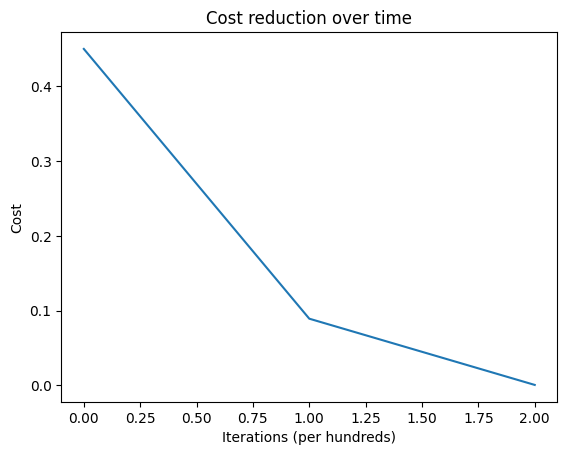

In [126]:
layer_dims = [784, 128, 64, 10]  
activations = ["relu", "relu", "softmax"]

# Train the model
parameters, costs = nnlayer(X_train,Y_train, layer_dims, activations, optimizer="adam", learning_rate=0.1, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=2000, print_cost=True)

# Plotting the cost function
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Cost reduction over time')
plt.show()


In [127]:
def predict(X, parameters, activations):
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    caches = []
    
    for l in range(1, L + 1):
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A, cache = activate_forward(A_prev, W, b, activations[l-1])
        caches.append(cache)
    
    return A

# Predict on the test set
Y_pred = predict(X_test, parameters, activations)

# Compute accuracy
def compute_accuracy(Y_pred, Y_true):
    predictions = np.argmax(Y_pred, axis=0)
    labels = np.argmax(Y_true, axis=0)
    accuracy = np.mean(predictions == labels)
    return accuracy

accuracy = compute_accuracy(Y_pred, Y_test)
print(f"Test set accuracy: {accuracy * 100:.2f}%")



Test set accuracy: 89.00%


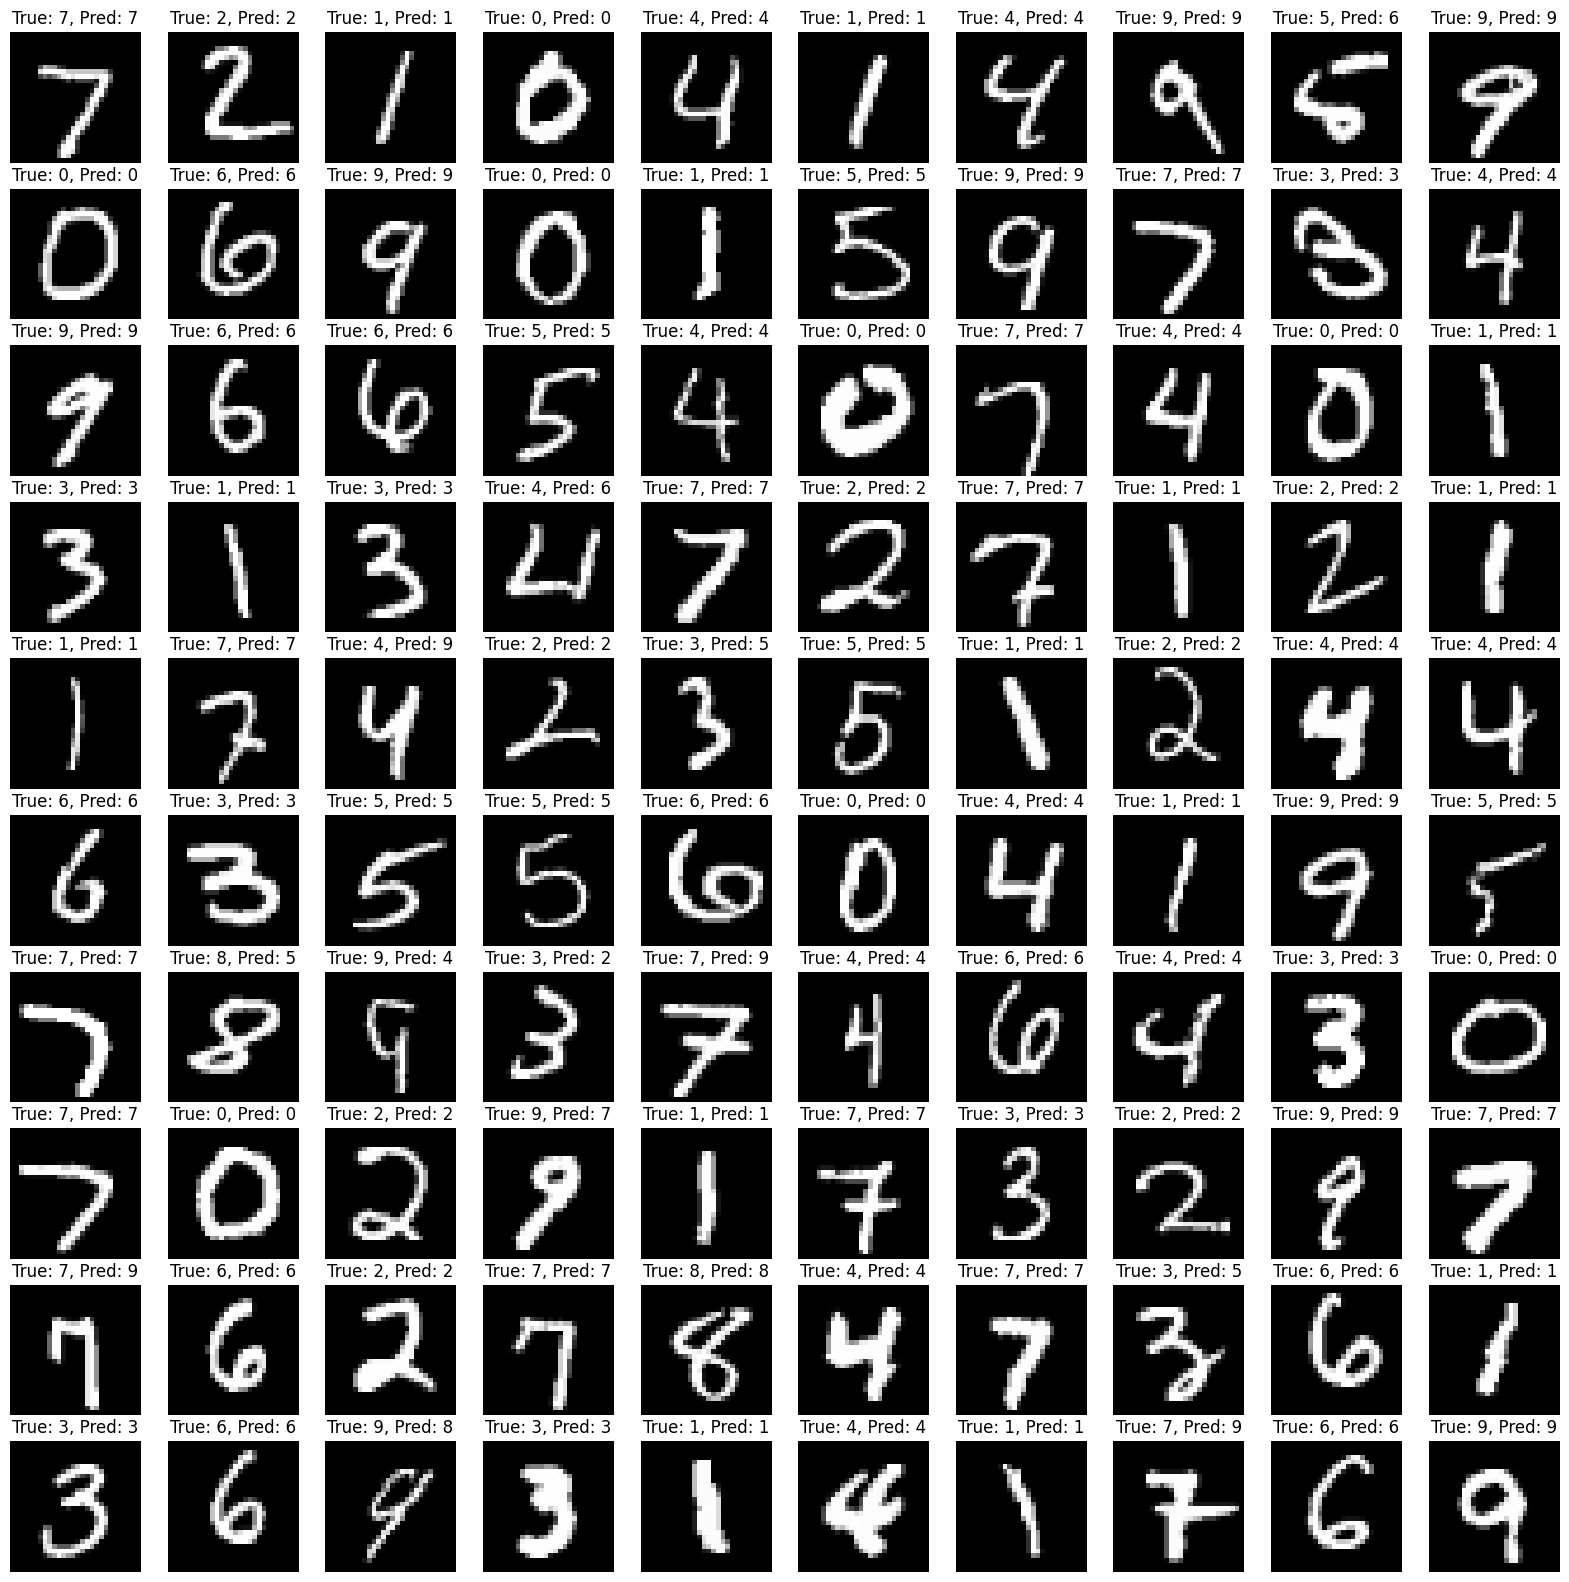

In [128]:
# visualise 100 of the mnist test dataset
# create 10x10 grid of images
# create 10x10 grid of corresponding outputs for the same
# create 10x10 grid of corresponding predictions for the same

def plot_mnist(X, Y_true, Y_pred):
    fig, axes = plt.subplots(10, 10, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:, i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f"True: {np.argmax(Y_true[:, i])}, Pred: {np.argmax(Y_pred[:, i])}")
    plt.show()

plot_mnist(X_test, Y_test, Y_pred)


# Testing the optimizers

We evaluate each of the optimizers for MNIST dataset and evaluate the performance of each optimizers on the convergence and its decay rate.

W1 shape: (128, 784)
b1 shape: (128, 1)
W2 shape: (64, 128)
b2 shape: (64, 1)
W3 shape: (10, 64)
b3 shape: (10, 1)
sgd accuracy: 14.50%
W1 shape: (128, 784)
b1 shape: (128, 1)
W2 shape: (64, 128)
b2 shape: (64, 1)
W3 shape: (10, 64)
b3 shape: (10, 1)
momentum accuracy: 14.50%
W1 shape: (128, 784)
b1 shape: (128, 1)
W2 shape: (64, 128)
b2 shape: (64, 1)
W3 shape: (10, 64)
b3 shape: (10, 1)
rmsprop accuracy: 86.00%
W1 shape: (128, 784)
b1 shape: (128, 1)
W2 shape: (64, 128)
b2 shape: (64, 1)
W3 shape: (10, 64)
b3 shape: (10, 1)
adam accuracy: 89.00%


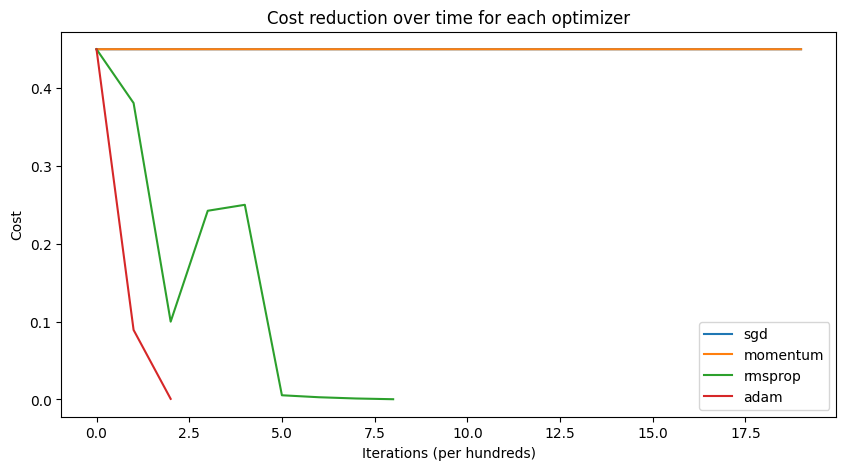

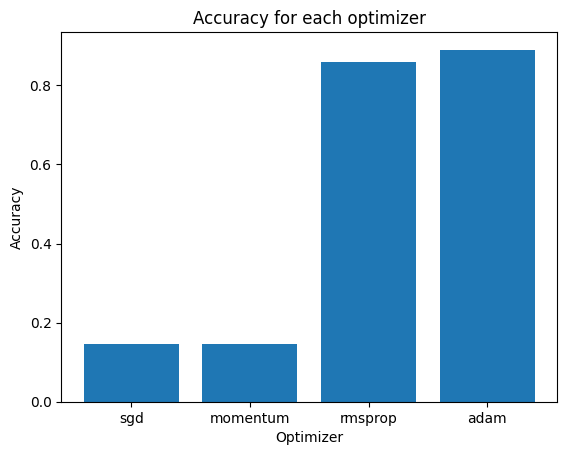

In [129]:
optimizers = ["sgd", "momentum", "rmsprop", "adam"]
accuracies = []
all_costs={}

for optimizer in optimizers:
    parameters, costs = nnlayer(X_train, Y_train, layer_dims, activations, optimizer=optimizer, learning_rate=0.1, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=2000, print_cost=False)
    all_costs[optimizer]=costs
    Y_pred = predict(X_test, parameters, activations)
    accuracy = compute_accuracy(Y_pred, Y_test)
    accuracies.append(accuracy)
    print(f"{optimizer} accuracy: {accuracy * 100:.2f}%")

# visualize the cost reductions over iterations time for each optimizers
plt.figure(figsize=(10, 5))
for i, optimizer in enumerate(optimizers):
    plt.plot(all_costs[optimizer], label=optimizer)
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Cost reduction over time for each optimizer')
plt.legend()
plt.show()

# visualize the accuracies for each optimizer
plt.bar(optimizers, accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Optimizer')
plt.title('Accuracy for each optimizer')
plt.show()
